<a href="https://colab.research.google.com/github/resign123/The-Hangman-Game/blob/main/hang_freq_entropy_etao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved.
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server.

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [ ]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving words_250000_train.txt to words_250000_train.txt


In [ ]:
vowels = ['a', 'e', 'i', 'o', 'u']

In [ ]:
def vowel_count(clean_word):
    count = 0
    for i in clean_word:
        if i in vowels:
            count = count+1.0
    return count/len(clean_word)

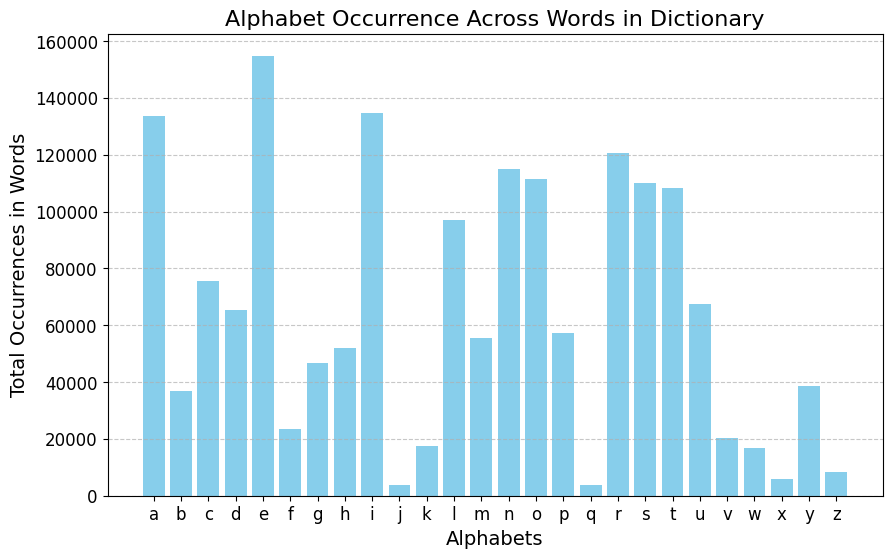

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

with open("words_250000_train.txt", "r") as f:
    words = [line.strip() for line in f]

alphabet_occurrence = {chr(i): 0 for i in range(97, 123)}

for word in words:
    unique_letters = set(word.lower())
    for letter in unique_letters:
        if letter in alphabet_occurrence:
            alphabet_occurrence[letter] += 1

letters = list(alphabet_occurrence.keys())
occur_counts = list(alphabet_occurrence.values())

plt.figure(figsize=(10, 6))
plt.bar(letters, occur_counts, color="skyblue")
plt.xlabel("Alphabets", fontsize=14)
plt.ylabel("Total Occurrences in Words", fontsize=14)
plt.title("Alphabet Occurrence Across Words in Dictionary", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
f = open("words_250000_train.txt", "r")
df = []
for x in f:
  df.append(x)

In [ ]:
for i in range(len(df)):
    df[i] = df[i].replace("\n", "")

In [ ]:
l=[]
for words in df:
    l.append(vowel_count(words))
l = pd.Series(l)
l.describe()

,0
count,227300.000000
mean,0.386889
std,0.095527
min,0.000000
25%,0.333333
50%,0.384615
75%,0.444444
max,1.000000


(array([1.2490e+03, 2.0000e+00, 6.8100e+02, 1.7410e+03, 6.7780e+03,
        3.2538e+04, 3.5853e+04, 3.6370e+04, 6.0189e+04, 1.2807e+04,
        2.8992e+04, 7.8220e+03, 7.7600e+02, 1.1180e+03, 1.0800e+02,
        1.8300e+02, 5.4000e+01, 1.0000e+00, 0.0000e+00]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <BarContainer object of 19 artists>)

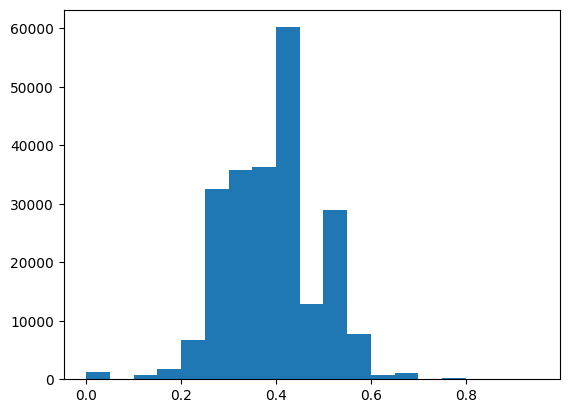

In [ ]:
bins = np.arange(0.0, 1.0, 0.05)
plt.hist(x = l, bins = bins)

In [ ]:
# From the above plot we can stastically say that if the number of vowels in it are greater than 0.55 times of its lenght than guessing a vowel will not be a good choice.

In [ ]:
max_length = 0
for words in df:
    if(len(words)>max_length):
        max_length = len(words)

In [ ]:
n_word_dictionary = {i:[] for i in range(3, 30)}
count = 3
while count<=max_length:
    for words in df:
        if(len(words)>=count):
            for i in range(len(words)-count+1):
                n_word_dictionary[count].append(words[i:i+count])
    count = count+1

In [ ]:
import collections
import math


In [ ]:
def func(new_dictionary):
    dictx = collections.Counter()
    for words in new_dictionary:
        temp = collections.Counter(words)
        for i in temp:
            temp[i] = 1
            dictx = dictx + temp
    return dictx

In [ ]:
def func2(n_word_dictionary, clean_word):
    new_dictionary = []
    l = len(clean_word)
    for dict_word in n_word_dictionary[l]:
        if re.match(clean_word,dict_word):
            new_dictionary.append(dict_word)
    return new_dictionary

In [ ]:
HANGMAN_URL = "https://www.trexsim.com/trexsim/hangman"

class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []

        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()

        self.current_dictionary = []





    def guess(self, word): # word input example: "_ p p _ e "
        ###############################################
        # Replace with your own "guess" function here #
        ###############################################
        guess_letter = '!'
        clean_word = word[::2].replace("_", ".")
        len_word = len(clean_word)

        if not hasattr(self, 'guess_counter'):
            self.guess_counter = 0  # Start at 0 guesses made

        total_tries = 6
        self.guess_counter += 1
        current_dictionary = self.current_dictionary
        new_dictionary = [
            dict_word for dict_word in current_dictionary
            if len(dict_word) == len_word and re.match(clean_word, dict_word)
        ]
        self.current_dictionary = new_dictionary

        c = func(new_dictionary)

        sorted_letter_count = c.most_common()


        if self.guess_counter == total_tries - 1 and len(new_dictionary) >= 4:
            entropy_scores = {}
            total_words = len(new_dictionary)

            letter_freq = {}
            for word in new_dictionary:
                for letter in set(word):
                    if letter not in self.guessed_letters:
                        letter_freq[letter] = letter_freq.get(letter, 0) + 1


            for letter, freq in letter_freq.items():
                match_count = freq
                no_match_count = total_words - freq

                p_match = match_count / total_words
                p_no_match = no_match_count / total_words

                # Calculate entropy
                entropy = 0
                if p_match > 0:
                    entropy -= p_match * math.log2(p_match)
                if p_no_match > 0:
                    entropy -= p_no_match * math.log2(p_no_match)


                weighted_entropy = entropy * (freq / total_words)
                entropy_scores[letter] = weighted_entropy


            if entropy_scores:

                max_freq = max(letter_freq.values())
                best_letters = [l for l, f in letter_freq.items()
                            if f == max_freq and l in entropy_scores]

                if best_letters:
                    guess_letter = max(best_letters,
                                    key=lambda x: entropy_scores[x])
                    self.guessed_letters.append(guess_letter)

            self.guess_counter += 1


        if guess_letter == '!':
            if self.guess_counter <= 2:
                priority_order = "etaoinshrdlu"

                max_freq = sorted_letter_count[0][1]
                candidates = [letter for letter, freq in sorted_letter_count if freq == max_freq]

                candidates.sort(key=lambda l: priority_order.index(l) if l in priority_order else float('inf'))

                for letter in candidates:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        self.guessed_letters.append(letter)
                        break
            else:
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        if letter in vowels and vowel_count(clean_word) > 0.55:
                            self.guessed_letters.append(letter)
                            continue
                        guess_letter = letter
                        self.guessed_letters.append(letter)
                        break

        if guess_letter == '!':
            new_dictionary = func2(n_word_dictionary, clean_word)
            c = func(new_dictionary)
            sorted_letter_count = c.most_common()


            if self.guess_counter <= 2:
                priority_order = "etaoinshrdlu"
                max_freq = sorted_letter_count[0][1]
                candidates = [letter for letter, freq in sorted_letter_count if freq == max_freq]


                candidates.sort(key=lambda l: priority_order.index(l) if l in priority_order else float('inf'))

                for letter in candidates:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        self.guessed_letters.append(letter)
                        break
            else:
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        if letter in vowels and vowel_count(clean_word) > 0.55:
                            self.guessed_letters.append(letter)
                            continue
                        guess_letter = letter
                        self.guessed_letters.append(letter)
                        break

        if guess_letter == '!':
            x = int(len(clean_word) / 2)
            if x >= 3:
                c = collections.Counter()
                for i in range(len(clean_word) - x + 1):
                    s = clean_word[i:i + x]
                    new_dictionary = func2(n_word_dictionary, s)
                    temp = func(new_dictionary)
                    c = c + temp
                sorted_letter_count = c.most_common()
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        self.guessed_letters.append(letter)
                        break

        if guess_letter == '!':
            x = int(len(clean_word) / 3)
            if x >= 3:
                c = collections.Counter()
                for i in range(len(clean_word) - x + 1):
                    s = clean_word[i:i + x]
                    new_dictionary = func2(n_word_dictionary, s)
                    temp = func(new_dictionary)
                    c = c + temp
                sorted_letter_count = c.most_common()
                for letter, instance_count in sorted_letter_count:
                    if letter not in self.guessed_letters:
                        guess_letter = letter
                        self.guessed_letters.append(letter)
                        break


        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    if letter in vowels and vowel_count(clean_word)>0.55:
                        self.guessed_letters.append(letter)
                        continue
                    guess_letter = letter
                    self.guessed_letters.append(letter)
                    break

        return guess_letter







    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################

    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary

    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary

        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)

                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))

                try:
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e

                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"

    def my_status(self):
        return self.request("/my_status", {})

    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        try:
            # response = self.session.request(
            response = requests.request(
                method or "GET",
                HANGMAN_URL + path,
                timeout=self.timeout,
                params=args,
                data=post_args)
        except requests.HTTPError as e:
            response = json.loads(e.read())
            raise HangmanAPIError(response)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result

class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object.
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [ ]:
api = HangmanAPI(access_token="a3c56ebe3822f7fdb7cb6204391884", timeout=2000)


## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [ ]:

api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status()
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))


Successfully start a new game! Game ID: ab90f9bfab3d. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': 'ab90f9bfab3d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ _ _ e '}
Guessing letter: i
Sever response: {'game_id': 'ab90f9bfab3d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ i _ e '}
Guessing letter: t
Sever response: {'game_id': 'ab90f9bfab3d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ t i _ e '}
Guessing letter: a
Sever response: {'game_id': 'ab90f9bfab3d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ a t i _ e '}
Guessing letter: v
Sever response: {'game_id': 'ab90f9bfab3d', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ a t i v e '}
Guessing letter: l
Sever response: {'game_id': 'ab90f9bfab3d', 'status': 'ongoing', 'tries_remains': 6, 'word': 'l e _ a t i v e '}
Guessing letter: r
Sever response: {'game_id': 'ab90f9bfab3d', 'status': 'ongoing', 'tries_remains': 5, '

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [ ]:
[initial_practice_runs, initial_recorded_runs, initial_recorded_successes, initial_practice_successes] = api.my_status()

num_games = 1000
current_successes = 0

for i in range(num_games):
    print(f'Playing {i + 1}th game')

    try:
        game_result = api.start_game(practice=1, verbose=True)
    except Exception as e:
        print(f"Error during game {i + 1}: {e}")
        break

    if game_result:
        current_successes += 1

    games_run = i + 1
    current_success_rate = current_successes / games_run
    print(f'Success rate after {games_run} games = {current_success_rate:.3f}')

    time.sleep(0.5)

[final_practice_runs, final_recorded_runs, final_recorded_successes, final_practice_successes] = api.my_status()

games_run_total = final_recorded_runs - initial_recorded_runs
current_success_rate_total = current_successes / games_run_total if games_run_total > 0 else 0

print(f'Total games run = {games_run_total}. Overall success rate = {current_success_rate_total:.3f}')

Streaming output truncated to the last 5000 lines.
Successfully start a new game! Game ID: 859285b6e758. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: e
Sever response: {'game_id': '859285b6e758', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ e _ _ _ '}
Guessing letter: r
Sever response: {'game_id': '859285b6e758', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ r _ _ _ e _ _ _ '}
Guessing letter: a
Sever response: {'game_id': '859285b6e758', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ r a _ _ e _ _ _ '}
Guessing letter: t
Sever response: {'game_id': '859285b6e758', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ r a _ _ e _ _ _ '}
Guessing letter: n
Sever response: {'game_id': '859285b6e758', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ r a _ _ e _ _ _ '}
Guessing letter: s
Sever response: {'game_id': '859285b6e758', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ r a _ _ e _ _ _ '}
Guessing letter: i
Sever response: {'gam

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [ ]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status()
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

ZeroDivisionError: division by zero